In [1]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
def low(df, curr, p):
    return min(df['Low'][range(curr - p + 1, curr + 1)])

def high(df, curr, p):
    return max(df['High'][range(curr - p + 1, curr + 1)])

In [3]:
def tri(i):
    global df
    return max((df['High'][i] - df['Low'][i]), abs(df['High'][i] - df['Close'][i-1]), abs(df['Low'][i] - df['Close'][i-1]))

def trip(curr, p):
    global df
    return sum([tri(i) for i in range(curr - p + 1, curr + 1)])

def atr(df, curr, p):
    return (1/p)*sum([tri(df, i) for i in range(curr - p, curr)])

In [4]:
def upmove(curr):
    global df
    return df['High'][curr] - df['High'][curr - 1]

def downmove(curr):
    global df
    return df['Low'][curr - 1] - df['Low'][curr]

def dmplus(curr):
    global df
    return max(0, upmove(curr))

def dmminus(curr):
    global df
    return max(0, downmove(curr))

def dmpplus(curr, p):
    global df
    return sum([dmplus(i) for i in range(curr - p + 1, curr + 1)])

def dmpminus(curr, p):
    global df
    return sum([dmminus(i) for i in range(curr - p + 1, curr + 1)])

def diplus(curr, p):
    global df
    return dmpplus(curr, p)/trip(curr, p)

def diminus(curr, p):
    global df
    return dmpminus(curr, p)/trip(curr, p)

def dx(curr, p):
    global df
    dp = diplus(curr, p)
    dm = diminus(curr, p)
    dmdf = dp - dm
    dpdf = dp + dm
    DX = abs(dmdf)/dpdf
    return DX, dp, dm

def adx(curr, p, q):
    global df
    DXS, dp, dm = map(list, zip(*[dx(i, p) for i in range(curr - q + 1, curr + 1)]))
    ADX = sum(DXS)/q
    return ADX, dp[-1], dm[-1]

In [5]:
#buy a certain amount BTC
#Now with TAXES YEAH
def buy_t(acc_usdt, acc_btc, price, buy_amount):
    if(acc_usdt >= buy_amount):
        acc_usdt -= (buy_amount - buy_amount*0.001)*price
        acc_btc += buy_amount
    return acc_usdt, acc_btc

#sell a certain amount BTC
#Now with TAXES YEAH
def sell_t(acc_usdt, acc_btc, price, sell_amount):
    if(acc_btc >= sell_amount):
        acc_usdt += (sell_amount - sell_amount*0.001)*price
        acc_btc -= sell_amount
    return acc_usdt, acc_btc

In [6]:
def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [7]:
def sell(price, weight):
    global acc_usdt
    global acc_btc
    
    out = "Trying to sell..."
    quantity = truncate(acc_btc*weight, 6)
    if quantity > 0.0001:
        acc_usdt, acc_btc = sell_t(acc_usdt, acc_btc, price, quantity)
        out = out + "Sold " + str(quantity) + "BTC at " + str(price)
        trade = True
        trade_type = "SELL"
    else:
        out = out + "Trade too small"
        trade = False
        trade_type = "NONE"
    return out, trade_type, trade

def buy(price, weight):
    global acc_usdt
    global acc_btc
    
    out = "Trying to buy..."
    quantity = truncate(((acc_usdt*weight)/price), 6)
    if quantity > 0.0001:
        acc_usdt, acc_btc = buy_t(acc_usdt, acc_btc, price, quantity)
        out = out + "Bought " + str(quantity) + "BTC at " + str(price)
        trade = True
        trade_type = "BUY"
    else:
        out = out + "Trade too small"
        trade = False
        trade_type = "NONE"
    return out, trade_type, trade


In [8]:
def trader(p, q, last_trade_price, last_trade_type):
    global acc_usdt
    global acc_btc
    global df
    
    i = df.index[-1]

    ADX, dp, dm = adx(i, p, q)
    
    weight = 1
    
    price = df['Close'][i]
    trade = True
    trade_type = "NONE"

    # BUY
    if(last_trade_type != 'BUY' and ((dp > dm and ADX > 0.25))):
        out, trade_type, trade = buy(price, weight)
    # SELL
    if(last_trade_type != 'SELL' and (dp < dm and ADX > 0.25)):
        out, trade_type, trade = sell(price, weight)
    
    if(trade_type == "NONE"):
        out = "No trade"
        trade = False
    
    if trade:
        return price, trade_type, dp, dm, ADX
    else:
        return 0, last_trade_type, dp, dm, ADX

In [9]:
p = 39
q = 10

# for p in range(1, 73):
folder_path = 'data\\5y\\'
file_name = 'BTCUSDT-30m-from-2017-08-to-2021-08'
csv_path = file_name +'.csv'

bdf = pd.read_csv(csv_path)

start = 0
end = len(bdf)

bdf = bdf.iloc[bdf.index[start:end]]

# for q in range(1, 73):

acc_value_hist = []
prev_time = 0
last_trade_price = 0
last_trade_type = "BUY"
out_df = pd.DataFrame([], columns = ["Timestamp", "High", "Low", "Close", "Action", "Account Value", "dp", "dm", "ADX"])
temp2_df = pd.DataFrame([], columns = ["Timestamp", "High", "Low", "Close", "Action", "Account Value", "dp", "dm", "ADX"])
acc_usdt = 0
acc_btc = 1 

for i in range(p + q, len(bdf)):
    df = bdf.loc[range(start + i - p - q, start + i + 1), :]
    df = df.astype(float)

    ret_price, last_trade_type, dp, dm, ADX = trader(p, q, last_trade_price, last_trade_type)
    if ret_price != 0:
        last_trade_price = ret_price
        trade_type = last_trade_type
    else:
        trade_type = "NONE"

    price = df['Close'][df.index[-1]]
    acc_value = acc_usdt + acc_btc*price

    temp_df = pd.DataFrame([[bdf['Open Time'][bdf.index[i]], bdf["High"][i], bdf["Low"][i], price, trade_type, acc_value, dp, dm, ADX]], columns = ["Timestamp", "High", "Low", "Close", "Action", "Account Value", "dp", "dm", "ADX"])
    temp2_df = temp2_df.append(temp_df)
    
    if i%1000==0:
        ind_pad = ""
        pri_pad = ""
        acc_pad = ""
        if i < 10000:
            ind_pad = " "
        if price < 10000:
            pri_pad = "  "
        if price > 10000 and price < 100000:
            pri_pad = " "
        if acc_value < 10000:
            acc_pad = "  "
        if acc_value > 10000 and acc_value < 100000:
            acc_pad = " "
        print(ind_pad + str(start + i) + ", price : " + pri_pad + "{:.2f}".format(price) + ", account value : " + acc_pad + "{:.2f}".format(acc_value))
        out_df = out_df.append(temp2_df)
        temp2_df = pd.DataFrame([], columns = ["Timestamp", "High", "Low", "Close", "Action", "Account Value", "dp", "dm", "ADX"])

print("Writing to file")
out_df = out_df.append(temp2_df)
print(str(len(out_df)) + " entries")
out_df.to_csv("test.csv")
print(str(p) + " " + str(q) + " " + str(price) + " " + str(acc_value))

 1000, price :   4458.00, account value :   4714.67
 2000, price :   4179.06, account value :   4256.96
 3000, price :   5550.01, account value :   4981.00
 4000, price :   7188.96, account value :   5944.73
 5000, price :  10699.68, account value :   8246.75
 6000, price :  17620.00, account value :  12206.65
 7000, price :  13754.38, account value :  13073.40
 8000, price :  10097.25, account value :  14018.23
 9000, price :  10242.00, account value :  19233.86
10000, price :   7878.00, account value :  19214.49
11000, price :   6598.99, account value :  17566.38
12000, price :   8830.01, account value :  20160.22
13000, price :   8286.00, account value :  18951.67
14000, price :   7636.40, account value :  18541.36
15000, price :   6139.00, account value :  16929.56
16000, price :   7316.13, account value :  19975.10
17000, price :   6262.86, account value :  21319.09
18000, price :   6993.01, account value :  20017.80
19000, price :   6323.86, account value :  19659.98
20000, price

<IPython.core.display.Javascript object>


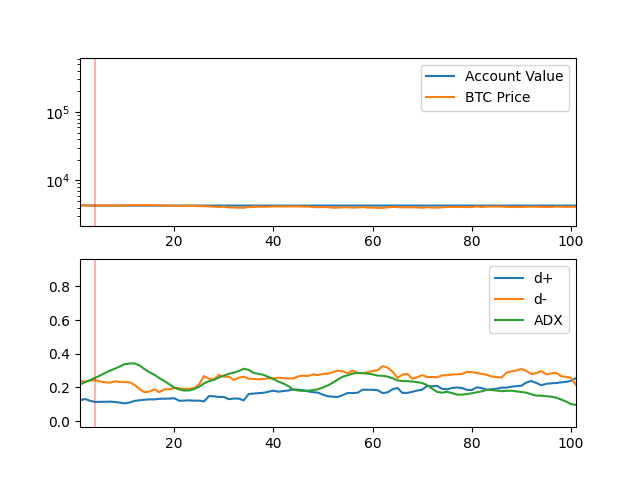

interactive(children=(FloatSlider(value=1.0, description='w', max=70235.0, min=1.0, step=10.0), Output()), _do…

<function __main__.update(w)>

In [10]:
%matplotlib notebook
from ipywidgets import *

def update(w):
    x = 100
    ax1.set_xlim(w, w + x)
    ax2.set_xlim(w, w + x)

csv_path = "test.csv"

df = pd.read_csv(csv_path)

ax1 = plt.subplot(2,1,1)
ax1.set_yscale("log")
ax1.plot(df['Account Value'], label = "Account Value")
ax1.plot(df['Close'], label = "BTC Price")
for i, e in enumerate(df['Action']):
    if e == "SELL":
        ax1.axvline(x=i, color="red", alpha=0.3)
    elif e == "BUY":
        ax1.axvline(x=i, color="green", alpha=0.3)
    elif e == "RESET":
        ax1.axvline(x=i, color="yellow", alpha=0.3)
plt.legend()

ax2 = plt.subplot(2,1,2)
ax2.plot(df['dp'], label = "d+")
ax2.plot(df['dm'], label = "d-")
ax2.plot(df['ADX'], label = "ADX")
for i, e in enumerate(df['Action']):
    if e == "SELL":
        ax2.axvline(x=i, color="red", alpha=0.3)
    elif e == "BUY":
        ax2.axvline(x=i, color="green", alpha=0.3)
    elif e == "RESET":
        ax2.axvline(x=i, color="yellow", alpha=0.3)
plt.legend()

interact(update, w = widgets.FloatSlider(value=1, min=1, max=len(df), step=10))